**Objetivos:**
Desarrollar, entrenar y comparar clasificadores supervisados usando SVM y Árboles de Decisión, aplicados a un caso técnico de detección de patrones en datos reales o simulados (sensores, comportamiento de usuarios, métricas de rendimiento, etc.).


## Análisis exploratorio de datos (EDA)


Dimensiones iniciales
---------------------
(172838, 16)

Dimensiones después de limpieza
-------------------------------
(172838, 17)

Esquema (tipo, nulos y cardinalidad)
------------------------------------
              columna            tipo         rol  nulos  nulos_%  unicos
0     date_first_seen  datetime64[ns]       fecha      0     0.00   81747
1            duration         float64    numérica   1074     0.62   18827
2               proto          object  categórica      0     0.00       4
3         src_ip_addr          object  categórica      0     0.00   10539
4              src_pt           int64    numérica      0     0.00   42293
5         dst_ip_addr          object  categórica      0     0.00   10478
6              dst_pt         float64    numérica      0     0.00   42065
7             packets           int64    numérica      0     0.00     223
8               bytes         float64    numérica      0     0.00    4695
9               flows           int64    numérica

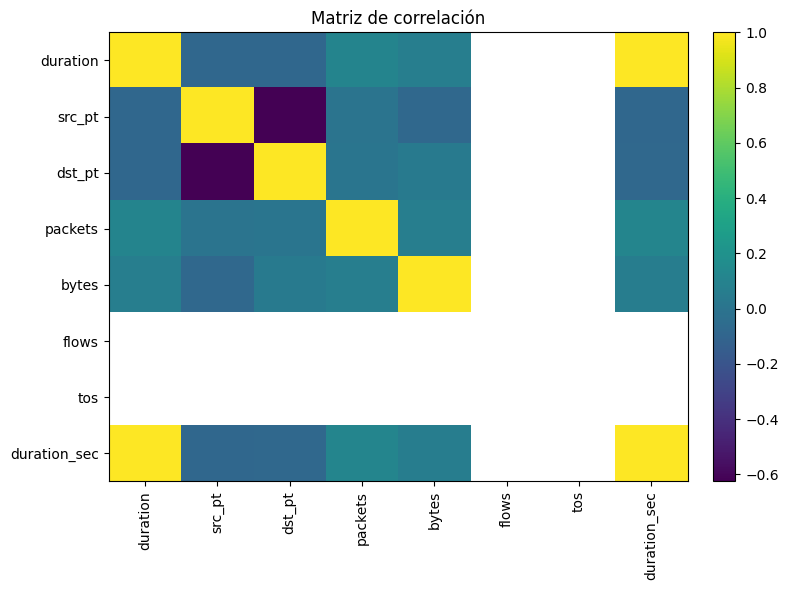

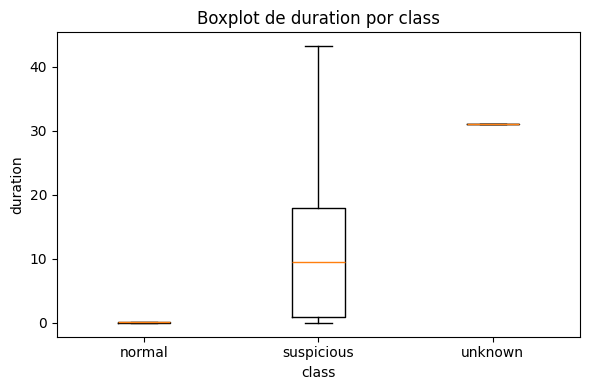

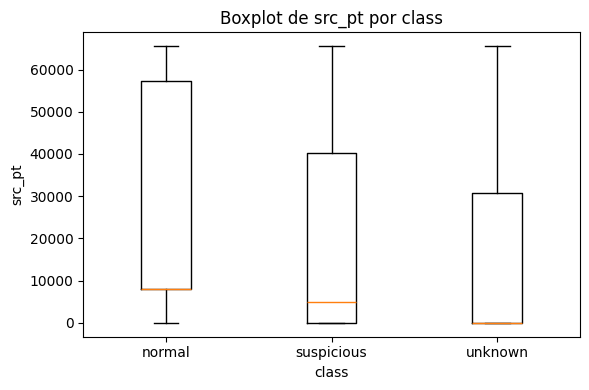

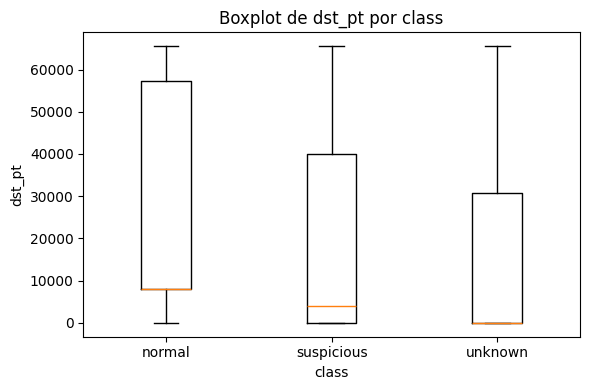

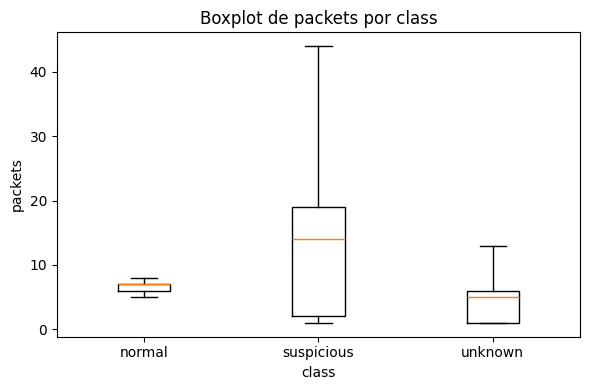

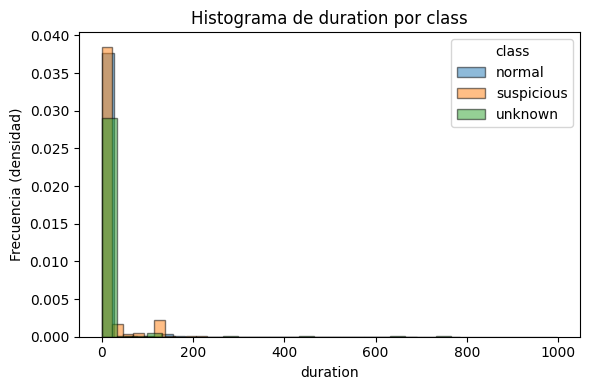

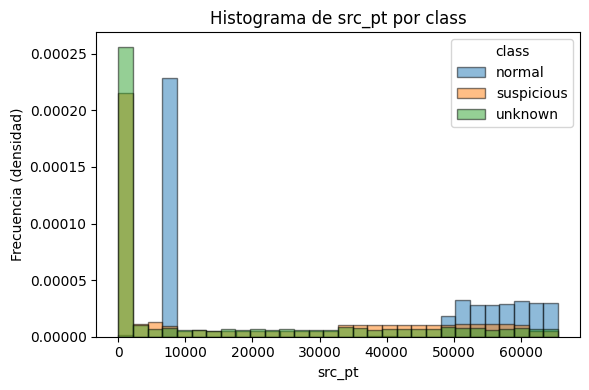

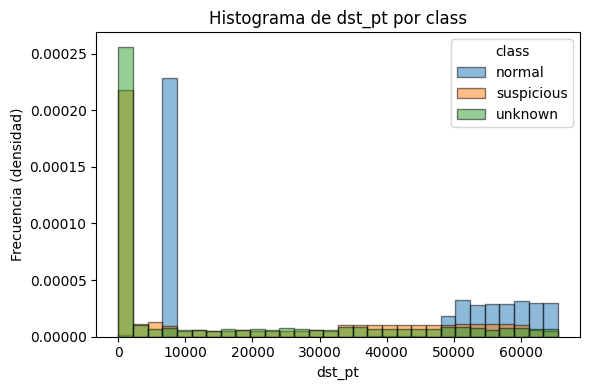

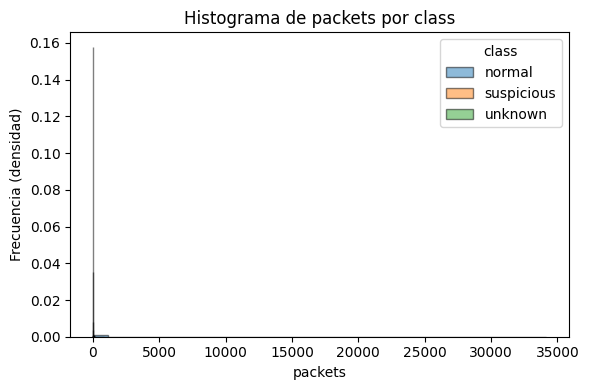


¡Listo! EDA completado.
-----------------------


In [ ]:
"""
EDA
Incluye:
1) Carga y limpieza básica
2) Descripción de variables y clases
3) Estadísticos descriptivos (numéricas)
4) Gráficos: matriz de correlación, boxplots, histogramas
"""

from pathlib import Path    
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------- 0) Configuración -----------------------
# Cambia la ruta a tu archivo si es necesario:
DATA_PATH = Path("/content/CIDDS-001-external-week1.csv")

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)


# ----------------------- Utilidades simples -----------------------
def parse_duration_simple(x: object) -> float:
    """Convierte strings 'Duration' a float de forma tolerante."""
    if pd.isna(x):
        return np.nan
    s = str(x)
    # deja solo dígitos y el primer punto
    out, dot = [], False
    for ch in s:
        if ch.isdigit():
            out.append(ch)
        elif ch == "." and not dot:
            out.append("."); dot = True
    try:
        return float("".join(out))
    except Exception:
        return np.nan


def print_title(txt):
    print("\n" + txt)
    print("-" * len(txt))


# ----------------------- 1) Carga y limpieza -----------------------
# Lee con ';' (si falla, intenta coma)
try:
    df = pd.read_csv(DATA_PATH, sep=";", engine="python")
except Exception:
    df = pd.read_csv(DATA_PATH, sep=",", engine="python")

print_title("Dimensiones iniciales")
print(df.shape)

# a) Normaliza nombres de columnas
df.columns = (
    df.columns
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.lower()
)

# b) Fechas (si existen)
for col in ["date_first_seen", "date", "timestamp", "datetime", "time"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# c) Duration a segundos (si existe)
if "duration" in df.columns and "duration_sec" not in df.columns:
    df["duration_sec"] = df["duration"].apply(parse_duration_simple)

# d) Convierte a numérico (coerce) las columnas 'object' que sean números
for c in df.columns:
    if df[c].dtype == "object":
        # Si la mayoría de los valores "parecen" numéricos, intenta convertir
        sample = df[c].dropna().astype(str).head(50)
        looks_numeric = (sample.str.match(r"^\s*-?\d+(\.\d+)?\s*$")).mean() > 0.6
        if looks_numeric:
            df[c] = pd.to_numeric(df[c], errors="coerce")

# e) Quita duplicados y filas totalmente vacías
df = df.drop_duplicates().dropna(how="all").reset_index(drop=True)

print_title("Dimensiones después de limpieza")
print(df.shape)


# ----------------------- 2) Describir variables y clases -----------------------
numeric_cols  = df.select_dtypes(include=[np.number]).columns.tolist()
datetime_cols = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
cat_cols      = [c for c in df.columns if c not in numeric_cols + datetime_cols]

schema = pd.DataFrame({
    "columna": df.columns,
    "tipo": [str(df[c].dtype) for c in df.columns],
    "rol": ["fecha" if c in datetime_cols else ("numérica" if c in numeric_cols else "categórica") for c in df.columns],
    "nulos": df.isna().sum().values,
    "nulos_%": (df.isna().sum().values / len(df) * 100).round(2),
    "unicos": [df[c].nunique(dropna=True) for c in df.columns]
})
print_title("Esquema (tipo, nulos y cardinalidad)")
print(schema)

# Variable objetivo (si existe)
target_col = "class" if "class" in df.columns else None
if target_col is not None:
    print_title(f"Distribución de clases ({target_col})")
    counts = df[target_col].value_counts(dropna=False)
    pct    = (df[target_col].value_counts(normalize=True, dropna=False) * 100).round(2)
    dist   = pd.DataFrame({"conteo": counts, "porcentaje_%": pct})
    print(dist)
else:
    print_title("No se encontró columna de clase (class)")


# ----------------------- 3) Estadísticos descriptivos -----------------------
if numeric_cols:
    print_title("Estadísticos descriptivos (variables numéricas)")
    print(df[numeric_cols].describe().T)
else:
    print_title("No hay variables numéricas para describir")


# ----------------------- 4) Visualizaciones -----------------------
# (Usamos solo matplotlib para mantenerlo simple)

# 4.1 Matriz de correlación (si hay >=2 numéricas)
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=range(len(corr.columns)), labels=corr.columns, rotation=90)
    plt.yticks(ticks=range(len(corr.index)), labels=corr.index)
    plt.title("Matriz de correlación")
    plt.tight_layout()
    plt.show()

# 4.2 Boxplots (por clase si existe; si no, globales)
box_vars = numeric_cols[:4]  # máximo 4 para no saturar
for col in box_vars:
    plt.figure(figsize=(6, 4))
    if target_col is not None:
        grupos = df[target_col].dropna().unique().tolist()
        data   = [df.loc[df[target_col] == g, col].dropna().values for g in grupos]
        labels = [str(g) for g in grupos]
        plt.boxplot(data, labels=labels, showfliers=False)
        plt.xlabel(target_col); plt.ylabel(col)
        plt.title(f"Boxplot de {col} por {target_col}")
    else:
        plt.boxplot(df[col].dropna().values, vert=True, showfliers=False)
        plt.ylabel(col); plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()

# 4.3 Histogramas (hasta 4 variables numéricas)
hist_vars = numeric_cols[:4]
for col in hist_vars:
    plt.figure(figsize=(6, 4))
    if target_col is not None:
        # Hist por clase (superpuestos, densidad)
        clases = df[target_col].dropna().unique().tolist()
        for cls in clases:
            vals = df.loc[df[target_col] == cls, col].dropna()
            plt.hist(vals, bins=30, alpha=0.5, density=True, label=str(cls), edgecolor="black")
        plt.legend(title=target_col)
        plt.title(f"Histograma de {col} por {target_col}")
    else:
        plt.hist(df[col].dropna(), bins=30, edgecolor="black")
        plt.title(f"Histograma de {col}")
    plt.xlabel(col); plt.ylabel("Frecuencia (densidad)")
    plt.tight_layout()
    plt.show()

print_title("¡Listo! EDA completado.")

PREPROCESAMIENTO

In [17]:
# =====================  PREPROCESAMIENTO =====================
# Objetivo: preparar X e y, imputar nulos, escalar numéricas y codificar categóricas.
# Luego dividir en train/test (80/20).

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

# --- 5.1 Definir variables de entrada (X) y objetivo (y) ---
target_col = "class" if "class" in df.columns else None

# Quitamos columnas datetime y la etiqueta del conjunto de features
cols_a_excluir = set(datetime_cols + ([target_col] if target_col else []))
feature_cols = [c for c in df.columns if c not in cols_a_excluir]

X = df[feature_cols].copy()
y = df[target_col].copy() if target_col else None

# Identificar columnas numéricas y categóricas (dentro de X)
num_features = [c for c in X.columns if c in numeric_cols]
cat_features = [c for c in X.columns if c in cat_cols]

# (Opcional) evitar explosión de dimensionalidad en categóricas muy grandes:
# Descomenta si lo necesitas
# max_uniques = 100
# high_card = [c for c in cat_features if df[c].nunique() > max_uniques]
# print("Categóricas de alta cardinalidad (no codificadas por defecto):", high_card)
# cat_features = [c for c in cat_features if df[c].nunique() <= max_uniques]

# --- 5.2 Pipelines de preprocesamiento ---
num_pipeline = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),   # nulos numéricos -> mediana
    ("scaler", StandardScaler())                 # escalado (media 0, var 1)
])

# Compatibilidad con versiones de sklearn (sparse vs sparse_output)
ohe_kwargs = {"handle_unknown": "ignore"}
try:
    OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    ohe_kwargs["sparse_output"] = True
except TypeError:
    ohe_kwargs["sparse"] = True

cat_pipeline = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),  # nulos categóricos -> moda
    ("ohe", OneHotEncoder(**ohe_kwargs))               # one-hot
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
    ],
    remainder="drop"  # descarta columnas no listadas
)

# --- 5.3 Split 80/20 (estratificado si hay etiqueta) ---
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
else:
    X_train, X_test = train_test_split(X, test_size=0.20, random_state=42)
    y_train = y_test = None

# --- 5.4 Ajustar en train y transformar ambos ---
X_train_pre = preprocess.fit_transform(X_train)
X_test_pre  = preprocess.transform(X_test)

# --- 5.5 Diagnóstico rápido ---
def _shape_to_text(M):
    # M puede ser ndarray o matriz dispersa
    try:
        return f"{M.shape} (sparse={hasattr(M, 'toarray')})"
    except Exception:
        return str(getattr(M, 'shape', 'N/A'))

print("\nPreprocesamiento completado")
print("-" * 30)
print(f"Features originales: {len(feature_cols)}  | Numéricas: {len(num_features)}  | Categóricas: {len(cat_features)}")
print(f"X_train_pre shape: {_shape_to_text(X_train_pre)}")
print(f"X_test_pre  shape: {_shape_to_text(X_test_pre)}")
if y is not None:
    print("Distribución de y (train):")
    print(y_train.value_counts(normalize=True).round(3))



Preprocesamiento completado
------------------------------
Features originales: 15  | Numéricas: 8  | Categóricas: 7
X_train_pre shape: (138270, 17317) (sparse=True)
X_test_pre  shape: (34568, 17317) (sparse=True)
Distribución de y (train):
class
suspicious    0.621
normal        0.287
unknown       0.092
Name: proportion, dtype: float64


MODELO ÁRBOL DE DECISION


Modelo 1: Árbol de decisión — Resultados
----------------------------------------
Accuracy: 0.9984 | F1 macro: 0.9967

Classification report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      9921
  suspicious       1.00      1.00      1.00     21469
     unknown       1.00      0.99      0.99      3178

    accuracy                           1.00     34568
   macro avg       1.00      1.00      1.00     34568
weighted avg       1.00      1.00      1.00     34568



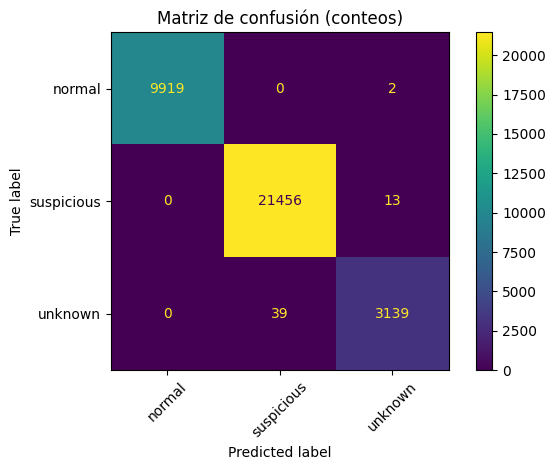

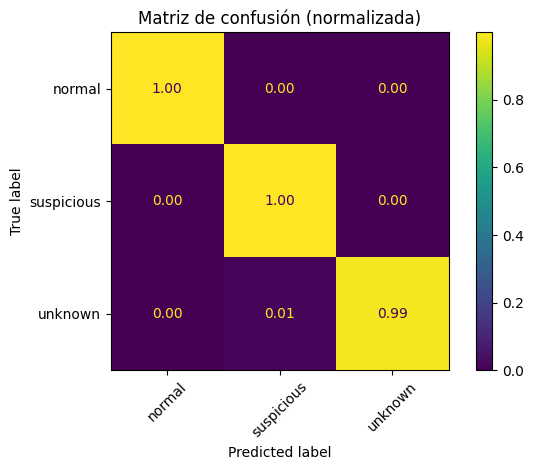


Top 20 features por importancia (árbol)
---------------------------------------
                         feature  importance
17311               flags_.AP.SF    0.356973
7                   duration_sec    0.311735
4                          bytes    0.159822
2                         dst_pt    0.048680
1                         src_pt    0.026591
0                       duration    0.024476
8644   src_ip_addr_OPENSTACK_NET    0.014286
17288  dst_ip_addr_OPENSTACK_NET    0.014165
17303               flags_.A..S.    0.011665
17304               flags_.A..SF    0.008665
17299               flags_....S.    0.007161
17312               flags_.APRS.    0.001143
8983        dst_ip_addr_10163_29    0.001122
336         src_ip_addr_10163_29    0.001068
3                        packets    0.000842
2264       src_ip_addr_11860_140    0.000796
10932      dst_ip_addr_11860_140    0.000795
9370       dst_ip_addr_10496_103    0.000604
722        src_ip_addr_10496_103    0.000577
8486   src_ip_addr_

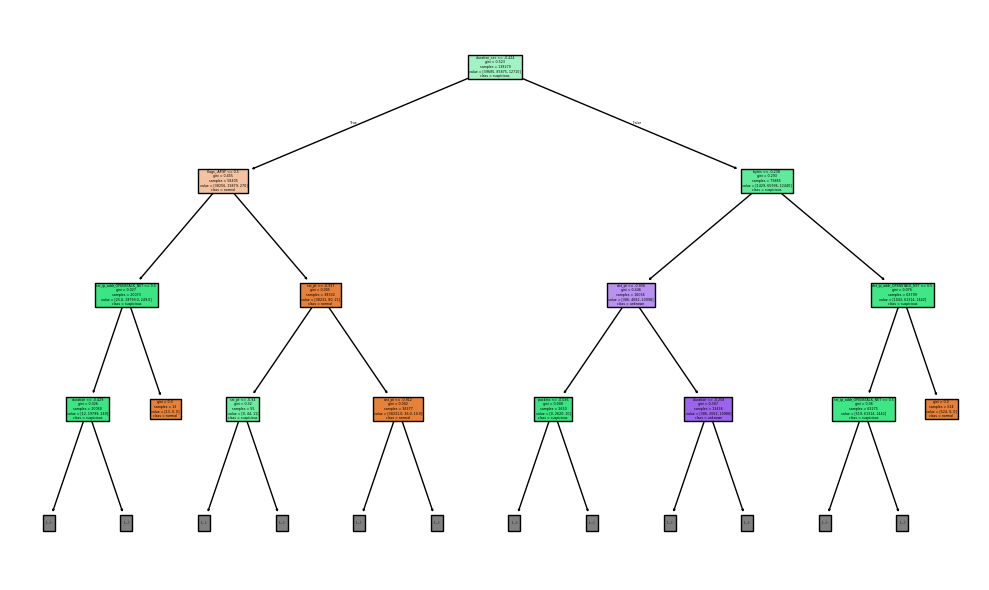

In [18]:
# =====================  MODELO 1: Árbol de decisión =====================
# Requiere:
   #pip install scikit-learn

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def print_title(txt):
    print("\n" + txt)
    print("-" * len(txt))

if target_col is None:
    print_title("No se puede entrenar modelo sin columna objetivo 'class'.")
else:
    # Pipeline: usa el mismo 'preprocess' definido en el snippet anterior
    clf = DecisionTreeClassifier(
        criterion="gini",
        max_depth=None,            # puedes ajustar (p.ej., 6-20) para controlar sobreajuste
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", clf)
    ])

    # Entrenamiento (fit) y predicción
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas básicas
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    print_title("Modelo 1: Árbol de decisión — Resultados")
    print(f"Accuracy: {acc:.4f} | F1 macro: {f1_macro:.4f}\n")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión (conteos)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(xticks_rotation=45)
    plt.title("Matriz de confusión (conteos)")
    plt.tight_layout()
    plt.show()

    # Matriz de confusión normalizada por clase verdadera (fila)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=model.classes_)
    disp_norm.plot(xticks_rotation=45, values_format=".2f")
    plt.title("Matriz de confusión (normalizada)")
    plt.tight_layout()
    plt.show()

    # Importancia de variables (Top-20)
    # Reconstruye nombres de features transformados: primero numéricas, luego dummies de categóricas
    feature_names = []
    feature_names.extend(num_features)  # en el ColumnTransformer van primero

    try:
        ohe = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
        ohe_names = ohe.get_feature_names_out(cat_features).tolist()
    except Exception:
        # Fallback si la versión de sklearn no soporta get_feature_names_out
        ohe_names = [f"{c}__encoded" for c in cat_features]

    feature_names.extend(ohe_names)

    importances = model.named_steps["model"].feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(20)

    print_title("Top 20 features por importancia (árbol)")
    print(imp_df)

    # (Opcional) Visualizar el árbol (puede ser grande). Limita profundidad para legibilidad.
    plt.figure(figsize=(10, 6))
    plot_tree(model.named_steps["model"],
               max_depth=3, filled=True,
               feature_names=feature_names,
               class_names=model.classes_)
    plt.tight_layout()
    plt.show()

MODELO SVC


Fitting 3 folds for each of 4 candidates, totalling 12 fits

Mejor configuración (CV)
------------------------
{'model__C': 2.0}
Mejor F1 macro (CV): 0.9830

Resultados en Test — LinearSVC
------------------------------
Accuracy: 0.9927 | F1 macro: 0.9865

Classification report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      4840
  suspicious       0.99      1.00      0.99      8795
     unknown       0.98      0.95      0.97      1652

    accuracy                           0.99     15287
   macro avg       0.99      0.98      0.99     15287
weighted avg       0.99      0.99      0.99     15287



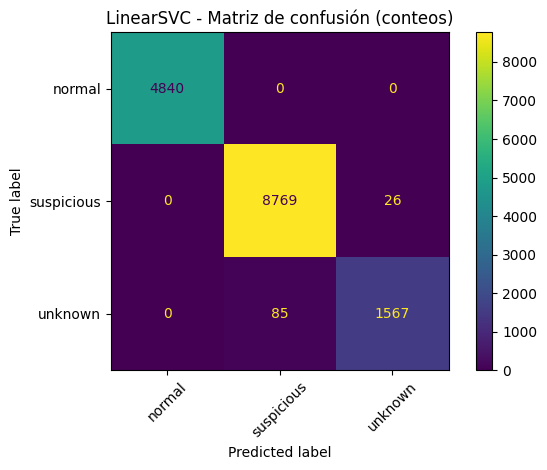

In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

def _title(t):
    print("\n"+t+"\n"+"-"*len(t))

if target_col is None:
    _title("No se puede entrenar sin columna objetivo 'class'.")
else:
    # Pipeline: usa el mismo 'preprocess' (imputación + OHE + escalado numérico)
    pipe_lin = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LinearSVC(
            dual="auto",
            class_weight="balanced",   # útil si hay desbalance
            max_iter=5000,
            random_state=42
        ))
    ])

    # Búsqueda pequeña (rápida) de C
    param_grid = {"model__C": [0.25, 0.5, 1.0, 2.0]}

    grid = GridSearchCV(
        estimator=pipe_lin,
        param_grid=param_grid,
        scoring="f1_macro",  # más justo que accuracy cuando hay desbalance
        cv=3,                # 3-fold para acelerar
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    _title("Mejor configuración (CV)")
    print(grid.best_params_)
    print(f"Mejor F1 macro (CV): {grid.best_score_:.4f}")

    # Evaluación en test
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    _title("Resultados en Test — LinearSVC")
    print(f"Accuracy: {acc:.4f} | F1 macro: {f1m:.4f}\n")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión (conteos)
    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(xticks_rotation=45)
    plt.title("LinearSVC - Matriz de confusión (conteos)")
    plt.tight_layout()
    plt.show()

Modelo — Random Forest (rápido, robusto, maneja no linealidad)*texto en cursiva*

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Mejor configuración (CV) — Random Forest
----------------------------------------
{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 300} | F1 macro (CV): 0.9983

Resultados en Test — Random Forest
----------------------------------
Accuracy: 0.9994 | F1 macro: 0.9989

Classification report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      4840
  suspicious       1.00      1.00      1.00      8795
     unknown       1.00      0.99      1.00      1652

    accuracy                           1.00     15287
   macro avg       1.00      1.00      1.00     15287
weighted avg       1.00      1.00      1.00     15287



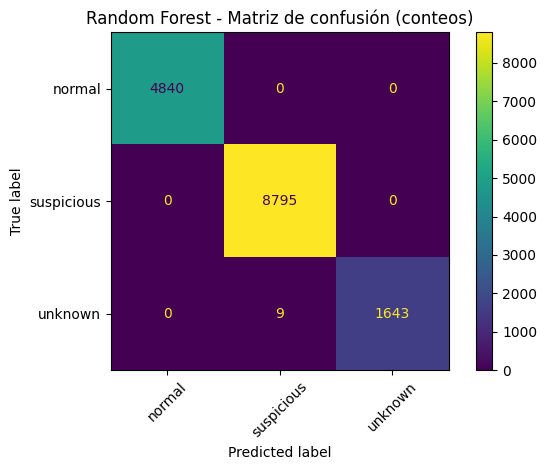


Top-20 Importancias — Random Forest
-----------------------------------
                        feature  importance
7                  duration_sec    0.114899
0                      duration    0.106577
4                         bytes    0.102741
2                        dst_pt    0.083697
3                       packets    0.083454
9124               flags_.AP.SF    0.076100
1                        src_pt    0.068072
4569  src_ip_addr_OPENSTACK_NET    0.044800
9116               flags_.A..S.    0.043373
9102  dst_ip_addr_OPENSTACK_NET    0.041625
9112               flags_....S.    0.034972
9118               flags_.A.R..    0.015112
2872       src_ip_addr_12875_68    0.013354
9101     dst_ip_addr_EXT_SERVER    0.011904
7452       dst_ip_addr_12875_68    0.011198
4568     src_ip_addr_EXT_SERVER    0.010824
9126               flags_.APRSF    0.008677
4577       dst_ip_addr_10004_36    0.007991
19         src_ip_addr_10004_36    0.007232
2519      src_ip_addr_12453_121    0.004799


In [8]:
# =====================  MODELO: Random Forest =====================
# Requiere: pip install scikit-learn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

def _title(t):
    print("\n"+t+"\n"+"-"*len(t))

if target_col is None:
    _title("No se puede entrenar sin columna objetivo 'class'.")
else:
    pipe_rf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            class_weight="balanced_subsample",
            random_state=42
        )),
    ])

    # Grid pequeño para mantener agilidad
    param_grid = {
        "model__n_estimators": [150, 300],
        "model__max_depth": [None, 12, 20],
        "model__min_samples_leaf": [1, 3]
    }

    grid = GridSearchCV(
        estimator=pipe_rf,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    _title("Mejor configuración (CV) — Random Forest")
    print(grid.best_params_, "| F1 macro (CV):", round(grid.best_score_, 4))

    best_rf = grid.best_estimator_
    y_pred = best_rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    _title("Resultados en Test — Random Forest")
    print(f"Accuracy: {acc:.4f} | F1 macro: {f1m:.4f}\n")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
    ConfusionMatrixDisplay(cm, display_labels=best_rf.classes_).plot(xticks_rotation=45)
    plt.title("Random Forest - Matriz de confusión (conteos)")
    plt.tight_layout(); plt.show()

    # ---------- Importancia de variables (Top-20) ----------
    # Reconstruir nombres de features (numéricas + dummies)
    feature_names = []
    feature_names.extend(num_features)

    try:
        ohe = best_rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
        ohe_names = ohe.get_feature_names_out(cat_features).tolist()
    except Exception:
        ohe_names = [f"{c}__encoded" for c in cat_features]

    feature_names.extend(ohe_names)

    importances = best_rf.named_steps["model"].feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_top = imp_df.sort_values("importance", ascending=False).head(20)

    _title("Top-20 Importancias — Random Forest")
    print(imp_top)


Modelo — Regresión Logística (lineal, interpretable, muy ágil)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Mejor configuración (CV) — Regresión Logística
----------------------------------------------
{'model__C': 2.0} | F1 macro (CV): 0.9733

Resultados en Test — Regresión Logística
----------------------------------------
Accuracy: 0.9861 | F1 macro: 0.9752

Classification report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      4840
  suspicious       0.99      0.98      0.99      8795
     unknown       0.91      0.96      0.94      1652

    accuracy                           0.99     15287
   macro avg       0.97      0.98      0.98     15287
weighted avg       0.99      0.99      0.99     15287



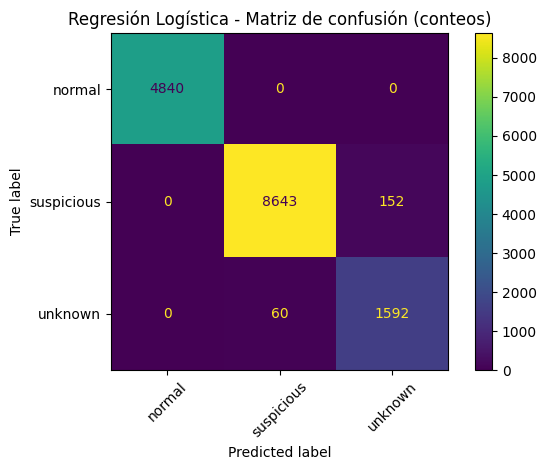


Top pesos por clase (|coef|)
----------------------------

Clase normal — Top-10:
                     feature    weight
0  dst_ip_addr_OPENSTACK_NET  7.962883
1  src_ip_addr_OPENSTACK_NET  7.848769
2               flags_.AP.SF  1.471902
3               flags_....S. -1.072927
4             attacktype_--- -0.999021
5      attackdescription_--- -0.999021
6               attackid_--- -0.999021
7       dst_ip_addr_10004_36 -0.927989
8                     src_pt  0.910636
9                     dst_pt  0.857919

Clase suspicious — Top-10:
                     feature    weight
0  src_ip_addr_OPENSTACK_NET -5.626690
1       dst_ip_addr_10004_36  5.046664
2  dst_ip_addr_OPENSTACK_NET -5.033054
3       src_ip_addr_10004_36  4.883071
4       dst_ip_addr_10004_35  3.556953
5       src_ip_addr_12875_68 -3.368271
6       src_ip_addr_10004_35  3.353022
7      src_ip_addr_12453_121 -2.901788
8      src_ip_addr_10956_200 -2.883019
9      src_ip_addr_13976_197  2.673979

Clase unknown — Top-10:
      

In [9]:
# ===================== MODELO: Regresión Logística =====================
# Requiere: pip install scikit-learn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def _title(t):
    print("\n"+t+"\n"+"-"*len(t))

if target_col is None:
    _title("No se puede entrenar sin columna objetivo 'class'.")
else:
    # 'saga' soporta alta dimensionalidad y matrices dispersas (OHE)
    pipe_lr = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            solver="saga",
            penalty="l2",
            max_iter=3000,
            n_jobs=-1,
            class_weight="balanced",
            random_state=42
        ))
    ])

    param_grid = {
        "model__C": [0.25, 0.5, 1.0, 2.0]
    }

    grid = GridSearchCV(
        estimator=pipe_lr,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    _title("Mejor configuración (CV) — Regresión Logística")
    print(grid.best_params_, "| F1 macro (CV):", round(grid.best_score_, 4))

    best_lr = grid.best_estimator_
    y_pred = best_lr.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    _title("Resultados en Test — Regresión Logística")
    print(f"Accuracy: {acc:.4f} | F1 macro: {f1m:.4f}\n")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=best_lr.classes_)
    ConfusionMatrixDisplay(cm, display_labels=best_lr.classes_).plot(xticks_rotation=45)
    plt.title("Regresión Logística - Matriz de confusión (conteos)")
    plt.tight_layout(); plt.show()

    # ---------- Coeficientes más influyentes ----------
    # Reconstruimos nombres de features (num + dummies)
    feat_names = []
    feat_names.extend(num_features)
    try:
        ohe = best_lr.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
        ohe_names = ohe.get_feature_names_out(cat_features).tolist()
    except Exception:
        ohe_names = [f"{c}__encoded" for c in cat_features]
    feat_names.extend(ohe_names)

    coef = best_lr.named_steps["model"].coef_
    classes = best_lr.named_steps["model"].classes_

    _title("Top pesos por clase (|coef|)")
    if len(classes) == 2:
        w = coef[0]
        top_idx = np.argsort(np.abs(w))[::-1][:20]
        top_df = pd.DataFrame({"feature": np.array(feat_names)[top_idx], "weight": w[top_idx]})
        print(top_df)
    else:
        # Multiclase: muestra top-10 por clase
        for i, cls in enumerate(classes):
            w = coef[i]
            top_idx = np.argsort(np.abs(w))[::-1][:10]
            top_df = pd.DataFrame({"feature": np.array(feat_names)[top_idx], "weight": w[top_idx]})
            print(f"\nClase {cls} — Top-10:")
            print(top_df)


Comparación experimental


Tabla resumen de métricas (macro y weighted)
--------------------------------------------
                     Precision_macro  Recall_macro  F1_macro  Precision_weighted  Recall_weighted  F1_weighted
Modelo                                                                                                        
Árbol de Decisión             0.9982        0.9958    0.9970              0.9984           0.9984       0.9984
LinearSVC                     0.9914        0.9819    0.9865              0.9927           0.9927       0.9927
Random Forest                 0.9997        0.9982    0.9989              0.9994           0.9994       0.9994
Regresión Logística           0.9686        0.9821    0.9752              0.9866           0.9861       0.9863


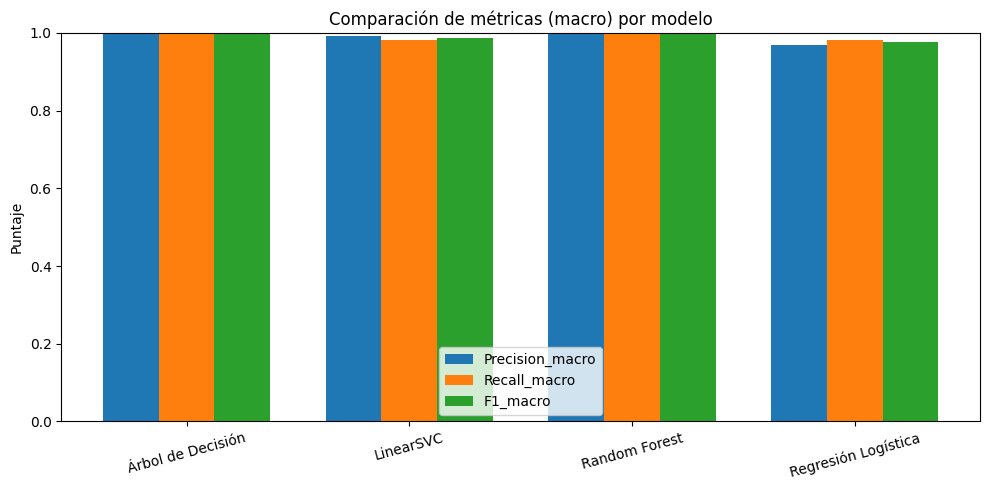

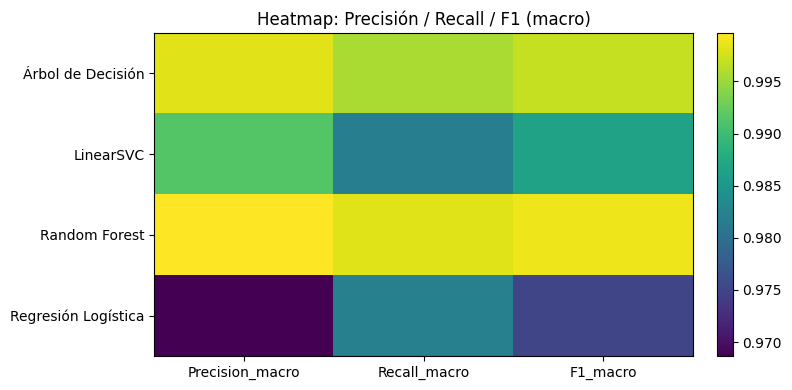

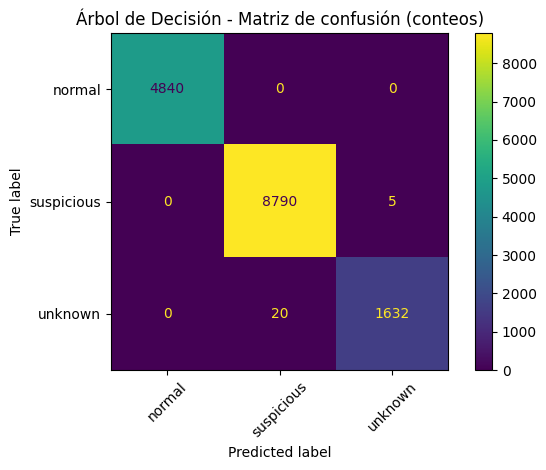

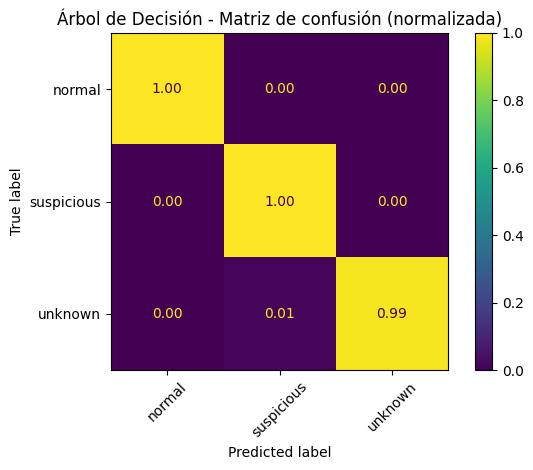

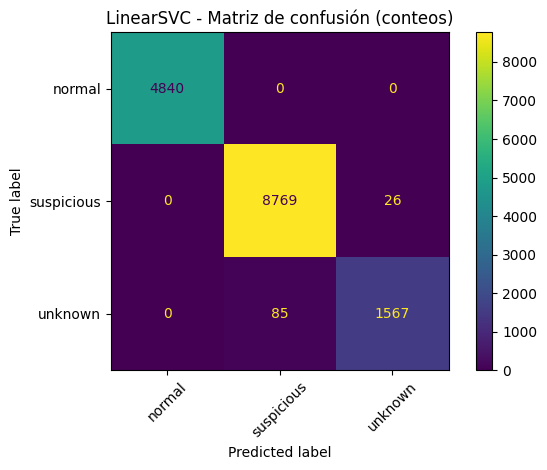

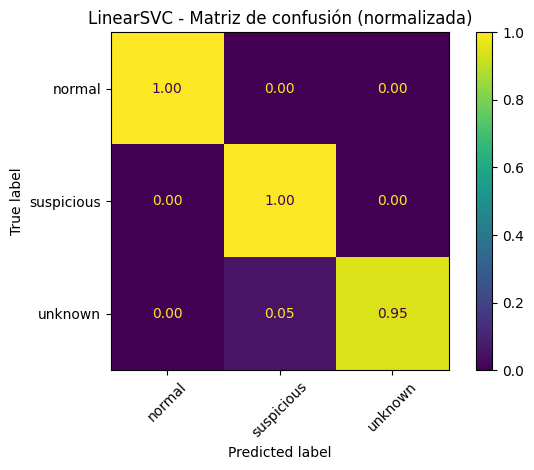

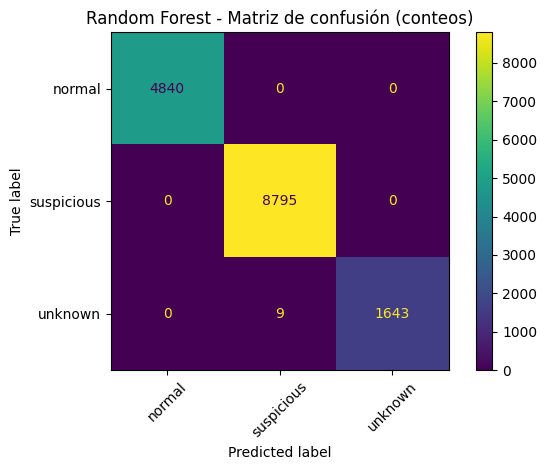

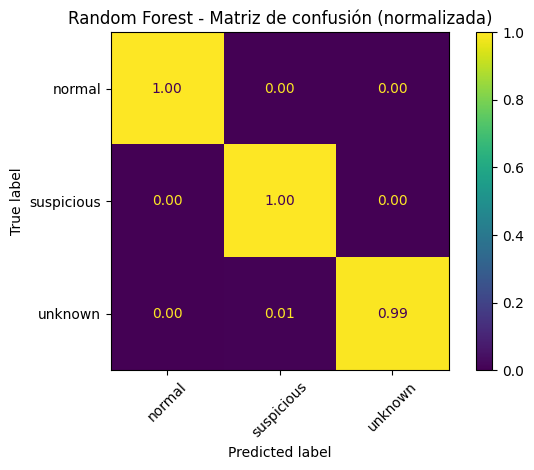

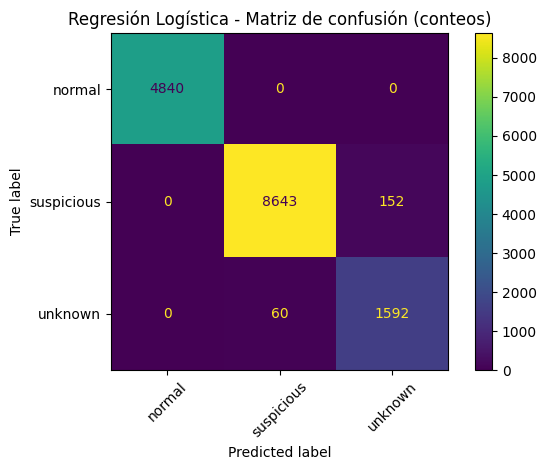

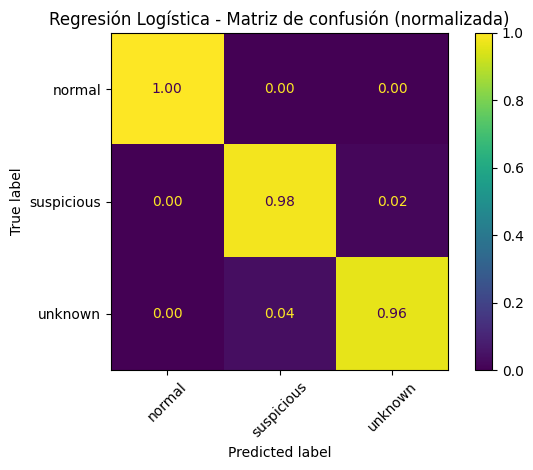

In [10]:
# ===================== MÉTRICAS Y COMPARACIÓN =====================
# Calcula:
# - Precisión, Recall, F1-score (macro y weighted)
# - Matriz de confusión (conteos y normalizada)
# - Tabla resumen por modelo
# - Gráficos comparativos (barplot y heatmap)

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _title(t):
    print("\n"+t+"\n"+"-"*len(t))

def evaluate_model(name, estimator, X_test, y_test):
    """Devuelve métricas y matriz de confusión para un estimador ya entrenado."""
    y_pred = estimator.predict(X_test)
    metrics = {
        "Modelo": name,
        "Precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "Recall_macro":    recall_score(y_test, y_pred, average="macro", zero_division=0),
        "F1_macro":        f1_score(y_test, y_pred, average="macro", zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall_weighted":    recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1_weighted":        f1_score(y_test, y_pred, average="weighted", zero_division=0),
    }
    classes = estimator.classes_ if hasattr(estimator, "classes_") else np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    return metrics, cm, classes

# --- Registra aquí los modelos que TENGAS entrenados ---
# (Se agregan si existen para que el snippet sea plug-and-play)
models_to_eval = []

# Modelo 1: Árbol de Decisión (pipeline llamado 'model' en el snippet previo)
if "model" in globals():
    models_to_eval.append(("Árbol de Decisión", model))

# Modelo 2: LinearSVC (versión compacta, guardado en 'best_model')
if "best_model" in globals():
    models_to_eval.append(("LinearSVC", best_model))

# Modelo 3A: Random Forest
if "best_rf" in globals():
    models_to_eval.append(("Random Forest", best_rf))

# Modelo 3B: Regresión Logística
if "best_lr" in globals():
    models_to_eval.append(("Regresión Logística", best_lr))

if not models_to_eval:
    _title("No se encontraron modelos entrenados para evaluar.")
else:
    # --- Evaluación y tabla resumen ---
    rows = []
    cms = {}   # guarda (cm, classes) por modelo

    for name, est in models_to_eval:
        m, cm, classes = evaluate_model(name, est, X_test, y_test)
        rows.append(m)
        cms[name] = (cm, classes)

    results_df = pd.DataFrame(rows).set_index("Modelo")
    _title("Tabla resumen de métricas (macro y weighted)")
    print(results_df.round(4))

    # (Opcional) guarda la tabla
    # results_df.to_csv("metricas_resumen_modelos.csv", index=True)

    # --- Visualización: barplot de métricas macro ---
    metrics_to_plot = ["Precision_macro", "Recall_macro", "F1_macro"]
    x = np.arange(len(results_df.index))
    width = 0.25

    plt.figure(figsize=(10, 5))
    for i, m in enumerate(metrics_to_plot):
        plt.bar(x + i*width, results_df[m].values, width=width, label=m)
    plt.xticks(x + width, results_df.index, rotation=15)
    plt.ylim(0, 1.0)
    plt.ylabel("Puntaje")
    plt.title("Comparación de métricas (macro) por modelo")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Visualización: heatmap simple de métricas macro ---
    M = results_df[metrics_to_plot].values
    plt.figure(figsize=(8, 4))
    im = plt.imshow(M, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.yticks(ticks=np.arange(len(results_df.index)), labels=results_df.index)
    plt.xticks(ticks=np.arange(len(metrics_to_plot)), labels=metrics_to_plot, rotation=0)
    plt.title("Heatmap: Precisión / Recall / F1 (macro)")
    plt.tight_layout()
    plt.show()

    # --- Matrices de confusión por modelo ---
    for name, (cm, classes) in cms.items():
        # Conteos
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(xticks_rotation=45)
        plt.title(f"{name} - Matriz de confusión (conteos)")
        plt.tight_layout()
        plt.show()

        # Normalizada por filas (recall por clase)
        cm_norm = cm / cm.sum(axis=1, keepdims=True)
        disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
        disp_norm.plot(xticks_rotation=45, values_format=".2f")
        plt.title(f"{name} - Matriz de confusión (normalizada)")
        plt.tight_layout()
        plt.show()
